In [267]:
#google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [268]:
#google colab
!pip install sweetviz
!pip install graphviz

In [269]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer,MinMaxScaler,QuantileTransformer,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [270]:
# Function to plot ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Data Loading

In [271]:
# reading data with pandas

# Jupyter
# data = pd.read_excel('Bankruptcy_data_Final.xlsx')

# google colab
data = pd.read_excel('/content/drive/MyDrive/MMA/MMA823_Finance/A1/Bankruptcy_data_Final.xlsx')

In [272]:
data.head()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,NaN,NaN,NaN,0
1,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126319,0.014278,0.040179,0
2,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368077,0.327909,0.566524,0
3,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.020809,-0.118904,-0.095890,0
4,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233089,0.146807,0.053030,0


In [273]:
data.shape

(92872, 13)

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 92867 non-null  float64
 1   Liquidity           92625 non-null  float64
 2   Profitability       92625 non-null  float64
 3   Productivity        92625 non-null  float64
 4   Leverage Ratio      92846 non-null  float64
 5   Asset Turnover      92625 non-null  float64
 6   Operational Margin  87315 non-null  float64
 7   Return on Equity    92864 non-null  float64
 8   Market Book Ratio   92815 non-null  float64
 9   Assets Growth       86171 non-null  float64
 10  Sales Growth        86171 non-null  float64
 11  Employee Growth     85862 non-null  float64
 12  BK                  92872 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 9.2 MB


In [275]:
# check missing values
data.isnull().sum()

EPS                      5
Liquidity              247
Profitability          247
Productivity           247
Leverage Ratio          26
Asset Turnover         247
Operational Margin    5557
Return on Equity         8
Market Book Ratio       57
Assets Growth         6701
Sales Growth          6701
Employee Growth       7010
BK                       0
dtype: int64

In [276]:
# summary statistics
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EPS,92867.0,-14.461355,2195.467288,-3.840000e+05,-0.140000,0.330000,1.530000,55339.00
Liquidity,92625.0,-2.631237,121.610921,-2.596852e+04,0.020000,0.190000,0.400000,1.00
Profitability,92625.0,-29.537274,677.230667,-7.968200e+04,-0.640000,0.070000,0.310000,140.58
Productivity,92625.0,-1.222870,35.885556,-5.093000e+03,-0.060000,0.060000,0.110000,1102.00
Leverage Ratio,92846.0,1.345316,253.038093,-7.811000e+03,0.000000,0.280000,0.820000,75970.38
Asset Turnover,92625.0,1.053613,2.115945,-3.159000e+01,0.390000,0.830000,1.390000,276.38
Operational Margin,87315.0,-7.915485,214.460079,-3.017570e+04,-0.030000,0.060000,0.140000,394.47
Return on Equity,92864.0,-2.112382,352.596902,-8.887514e+04,-0.080000,0.030000,0.070000,39500.00
Market Book Ratio,92815.0,358.506265,26063.637981,-3.151500e+06,11.200000,58.280000,240.140000,3455419.33
Assets Growth,86171.0,1.294075,73.769522,-1.000000e+00,-0.052596,0.051844,0.192062,14231.00


In [277]:
data.pivot_table(index='BK')

,Asset Turnover,Assets Growth,EPS,Employee Growth,Leverage Ratio,Liquidity,Market Book Ratio,Operational Margin,Productivity,Profitability,Return on Equity,Sales Growth
BK,,,,,,,,,,,,
0,1.051111,1.302374,-13.231823,0.341756,1.348228,-2.642535,360.279568,-7.945216,-1.226630,-29.666632,-1.934013,1.902797
1,1.466490,0.020853,-219.338251,0.618409,0.862939,-0.767256,60.481545,-3.146859,-0.602488,-8.193908,-31.832970,1.487656


In [278]:
# check target balance
data['BK'].value_counts()

0    92314
1      558
Name: BK, dtype: int64

In [279]:
import sweetviz as sv
report = sv.analyze(data, target_feat='BK')

#jupyter
# report.show_html('bankrupt.html')

#colab
report.show_html('/content/drive/MyDrive/MMA/MMA823_Finance/A1/bankrupt.html')

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/MMA/MMA823_Finance/A1/bankrupt.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Operational Margin

when operation margin is null, Asset Turnover is either 0 or nan, therefore calculation does not work

In [280]:
data[data['Operational Margin'].isnull()]['Productivity'].unique()

array([-0.06      , -0.05      , -0.12      , ..., -4.35416667,
       -7.616     , -0.18720517])

In [281]:
data[data['Operational Margin'].isnull()]['Asset Turnover'].unique()

array([ 0., nan])

## Train Test Split

In [282]:
X = data.drop(['BK'], axis=1)
y = data['BK']

In [283]:
# check X variable
X.head()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,NaN,NaN,NaN
1,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126319,0.014278,0.040179
2,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368077,0.327909,0.566524
3,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.020809,-0.118904,-0.095890
4,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233089,0.146807,0.053030


In [284]:
# check y variable
y.head()

0    0
1    0
2    0
3    0
4    0
Name: BK, dtype: int64

In [285]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [286]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((65010, 12), (65010,), (27862, 12), (27862,))

In [287]:
y_train.value_counts()

0    64607
1      403
Name: BK, dtype: int64

In [288]:
y_test.value_counts()

0    27707
1      155
Name: BK, dtype: int64

## Preprocessing: data_pipeline

In [289]:
# Making a customized column transformer to handle outliers

# https://nbviewer.jupyter.org/github/queirozfcom/python-sandbox/blob/master/python3/notebooks/pipelines-custom-steps/main.ipynb
# https://www.section.io/engineering-education/custom-transformer/

class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [290]:
# Function to Address Outliters 
def cap_data(df):
    for col in df.iloc[:,0:11]:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.05,0.95]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

In [291]:
# numeric features
numeric_features = X_train.select_dtypes(include='number').columns.tolist()
print(numeric_features)

['EPS', 'Liquidity', 'Profitability', 'Productivity', 'Leverage Ratio', 'Asset Turnover', 'Operational Margin', 'Return on Equity', 'Market Book Ratio', 'Assets Growth', 'Sales Growth', 'Employee Growth']


In [292]:
# build pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('remove_outlier', CustomTransformer(cap_data)),
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', QuantileTransformer(random_state=0)) #LG Baseline AUC 0.8818134930383261
])

    # ('scale', PowerTransformer(method='yeo-johnson'))   #LG Baseline AUC 0.7590968626770688
    # ('scale', MinMaxScaler())                           #LG Baseline AUC 0.5856486715247224
    # ('scale', QuantileTransformer(random_state=0))      #LG Baseline AUC 0.8818134930383261
    # ('scale', StandardScaler())                         #LG Baseline AUC 0.6302697466693522

In [293]:
from sklearn.compose import ColumnTransformer

data_pipeline = ColumnTransformer(transformers=[
    ('numeric', numeric_pipeline, numeric_features)
])

In [294]:
# fit entire data pipeline
data_pipeline.fit_transform(X_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[0.14764765, 0.34384384, 0.09271772, ..., 0.08613771, 1.        ,
        0.82782783],
       [0.26126126, 0.71521522, 0.34684685, ..., 0.38348346, 0.11201222,
        0.42984234],
       [0.35535536, 0.        , 0.        , ..., 0.        , 0.31081081,
        0.37937938],
       ...,
       [0.48698699, 0.32732733, 0.56356356, ..., 0.91365916, 0.56978058,
        0.94499184],
       [0.57307307, 0.74474474, 0.68918919, ..., 0.90114555, 0.91974056,
        0.92913395],
       [1.        , 0.27877878, 0.48898899, ..., 0.85166528, 0.3595267 ,
        0.68518519]])

In [295]:
# we can now use data_pipeline to transform X_train and X_test
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [296]:
col_names = X_train.columns.to_list()
X_train_processed = pd.DataFrame(X_train_transformed, columns=col_names)
data_transformed = pd.merge(X_train_processed, y_train, left_index=True, right_index=True)

In [297]:
# summary statistics - make sure outliter is fixed
data_transformed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EPS,45421.0,0.500731,0.292918,0.0,0.251752,0.499499,0.750751,1.0
Liquidity,45421.0,0.500362,0.292582,0.0,0.243744,0.504505,0.753754,1.0
Profitability,45421.0,0.501377,0.292669,0.0,0.251752,0.498999,0.752685,1.0
Productivity,45421.0,0.500478,0.291991,0.0,0.253253,0.512012,0.724224,1.0
Leverage Ratio,45421.0,0.500238,0.291202,0.0,0.174675,0.500000,0.750751,1.0
Asset Turnover,45421.0,0.500209,0.293823,0.0,0.250751,0.501502,0.751251,1.0
Operational Margin,45421.0,0.500455,0.291400,0.0,0.251251,0.515015,0.746747,1.0
Return on Equity,45421.0,0.501383,0.292374,0.0,0.249750,0.496496,0.766767,1.0
Market Book Ratio,45421.0,0.499820,0.292439,0.0,0.249917,0.500559,0.748201,1.0
Assets Growth,45421.0,0.497484,0.290549,0.0,0.251250,0.498585,0.749605,1.0


In [298]:
#Plot transformed data

# import sweetviz as sv
# report = sv.analyze(data_transformed, target_feat='BK')

# #jupyter
# # report.show_html('bankrupt.html')

# #colab
# report.show_html('/content/drive/MyDrive/MMA/MMA823_Finance/A1/bankrupt_processed_std.html')

# Set Confusion Matrix Threshold

In [299]:
class_threshold = 0.5


## Model Training: Logistic Regression baseline model

In [300]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123)

In [301]:
lr_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', lr_model)])

In [302]:
# fit pipeline with model
lr_pipeline.fit(X_train, y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa66eeb3110>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [303]:
# predict probability on X_test
y_pred_proba = lr_pipeline.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[9.90012073e-01, 9.98792675e-03],
       [9.99011765e-01, 9.88235021e-04],
       [9.99292383e-01, 7.07617461e-04],
       ...,
       [9.99449487e-01, 5.50512670e-04],
       [9.99089211e-01, 9.10789329e-04],
       [9.78076746e-01, 2.19232536e-02]])

In [304]:
# AUC on test set
roc_auc_score(y_test, y_pred_proba[:,1])

0.8794628584601306

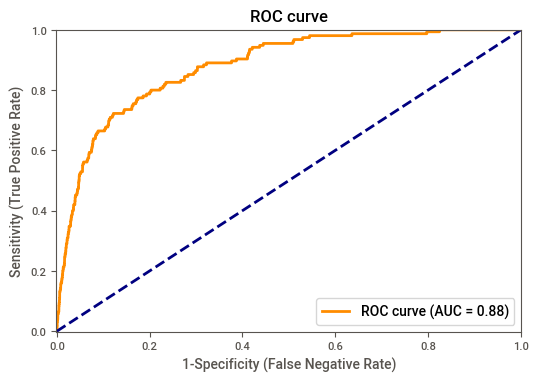

In [305]:
plot_roc(y_test, y_pred_proba[:,1])

In [306]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[27707     0]
 [  155     0]]


In [307]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27707
           1       0.00      0.00      0.00       155

    accuracy                           0.99     27862
   macro avg       0.50      0.50      0.50     27862
weighted avg       0.99      0.99      0.99     27862



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Training: Logistic Regression, Random Under Sampler

unable to predict positive scenarios (confusion matrix) after hyperparameter tuning

In [308]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_transformed, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [309]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns.to_list())
y_train_resampled = pd.DataFrame(y_train_resampled, columns=['BK'])

In [310]:
X_train_resampled.shape, y_train_resampled.shape

((806, 12), (806, 1))

In [311]:
y_train_resampled.value_counts()

BK
1     403
0     403
dtype: int64

In [312]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123)

In [313]:
lr_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', lr_model)])

# fit pipeline with model
lr_pipeline.fit(X_train_resampled, y_train_resampled)

# predictions from pipeline
y_pred = lr_pipeline.predict(X_test)
y_pred

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (806). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


capping the  Sales Growth


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([1, 0, 0, ..., 1, 0, 1])

In [314]:
# predict probability on X_test
y_pred_proba = lr_pipeline.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[0.01198569, 0.98801431],
       [0.57434362, 0.42565638],
       [0.56859545, 0.43140455],
       ...,
       [0.40269092, 0.59730908],
       [0.58484153, 0.41515847],
       [0.03926073, 0.96073927]])

In [315]:
# AUC on test set
roc_auc_score(y_test, y_pred_proba[:,1])

0.84855987249059

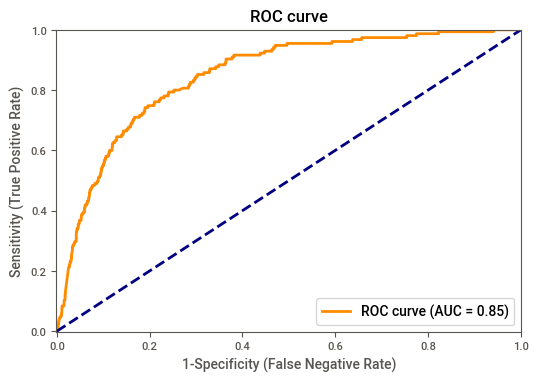

In [316]:
plot_roc(y_test, y_pred_proba[:,1])

In [317]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[12120 15587]
 [    7   148]]


In [318]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(12120, 15587, 7, 148)

In [319]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"model__penalty": ['l2','l1'],
                 "model__C": np.logspace(0, 4, 10)
                 }
            ]

In [320]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(lr_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [321]:
gridsearch_model = gridsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [322]:
y_pred_proba = gridsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[9.90012073e-01, 9.98792675e-03],
       [9.99011765e-01, 9.88235021e-04],
       [9.99292383e-01, 7.07617461e-04],
       ...,
       [9.99449487e-01, 5.50512670e-04],
       [9.99089211e-01, 9.10789329e-04],
       [9.78076746e-01, 2.19232536e-02]])

In [323]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8794628584601306

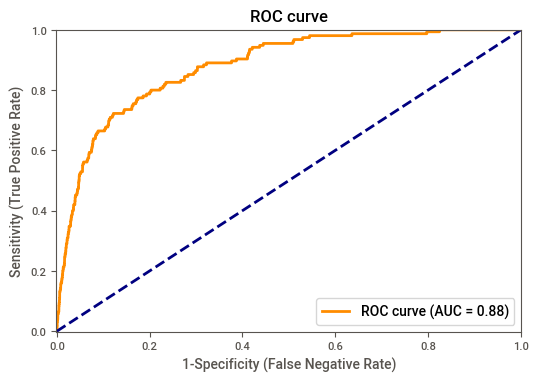

In [324]:
plot_roc(y_test, y_pred_proba[:,1])

In [325]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[27707     0]
 [  155     0]]


In [326]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(27707, 0, 155, 0)

In [327]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27707
           1       0.00      0.00      0.00       155

    accuracy                           0.99     27862
   macro avg       0.50      0.50      0.50     27862
weighted avg       0.99      0.99      0.99     27862



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Training: Logistic Regression, class_weight=balanced, hyperparameter tuning

https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6

In [328]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=123, class_weight='balanced')

In [329]:
lr_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', lr_model)])

In [330]:
# fit pipeline with model
lr_pipeline.fit(X_train, y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa66eeb3110>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [331]:
# predict probability on X_test
y_pred_proba = lr_pipeline.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[0.25784764, 0.74215236],
       [0.89656294, 0.10343706],
       [0.92707454, 0.07292546],
       ...,
       [0.81377543, 0.18622457],
       [0.95377511, 0.04622489],
       [0.22345618, 0.77654382]])

In [332]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8820319076232046

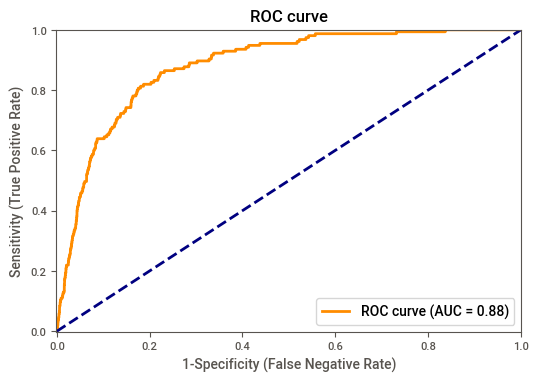

In [333]:
plot_roc(y_test, y_pred_proba[:,1])

In [334]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[22111  5596]
 [   28   127]]


In [335]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(22111, 5596, 28, 127)

In [336]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     27707
           1       0.02      0.82      0.04       155

    accuracy                           0.80     27862
   macro avg       0.51      0.81      0.47     27862
weighted avg       0.99      0.80      0.88     27862



In [337]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"model__penalty": ['l2','l1'],
                 "model__C": np.logspace(0, 4, 10)
                 }
            ]

In [338]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(lr_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [339]:
gridsearch_model = gridsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [340]:
gridsearch_model.best_score_

0.8196417949158317

In [341]:
gridsearch_model.best_params_

{'model__C': 166.81005372000593, 'model__penalty': 'l2'}

In [342]:
gridsearch_model.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa66f138790>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [343]:
# predict probability on X_test
y_pred_proba = gridsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[0.25720516, 0.74279484],
       [0.89708651, 0.10291349],
       [0.92738113, 0.07261887],
       ...,
       [0.81364561, 0.18635439],
       [0.95418971, 0.04581029],
       [0.22357174, 0.77642826]])

In [344]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8820055954184163

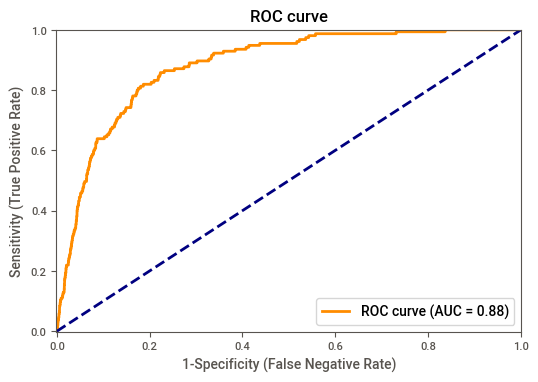

In [345]:
plot_roc(y_test, y_pred_proba[:,1])

In [346]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[22110  5597]
 [   28   127]]


In [347]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(22110, 5597, 28, 127)

In [348]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     27707
           1       0.02      0.82      0.04       155

    accuracy                           0.80     27862
   macro avg       0.51      0.81      0.47     27862
weighted avg       0.99      0.80      0.88     27862



## Model: Random Forest, balanced

In [349]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=123, class_weight='balanced')

In [350]:
rf_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', rf_model)])

In [351]:
# fit pipeline with model
rf_pipeline.fit(X_train, y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa66eeb3110>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [352]:
# predictions from pipeline
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth
capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [353]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8734756676139838

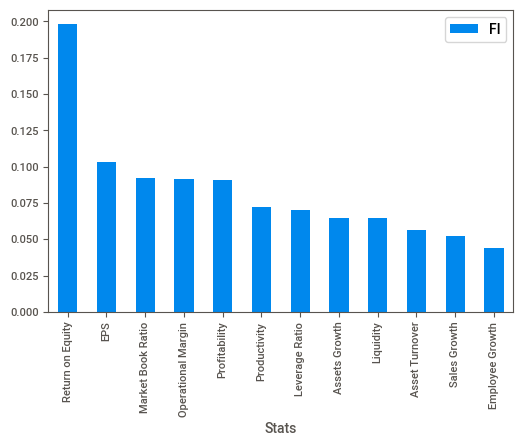

In [354]:
# plot feature_importances_
d = {'Stats':X_train.columns,'FI':rf_pipeline[1].feature_importances_}
df = pd.DataFrame(d)
df = df.sort_values(by='FI', ascending=False)
ax = df.plot.bar(x='Stats', y='FI', rot=90)

In [355]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {
                 "model__n_estimators": [10, 100],
                 "model__max_depth":[5,10,15],
                 "model__max_features":[0.8, "auto"]
                 }
            ]

In [356]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
randsearch = RandomizedSearchCV(rf_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [357]:
randsearch_model = randsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [358]:
#AUC
randsearch_model.best_score_

0.8245350629814043

In [359]:
randsearch_model.best_params_

{'model__max_depth': 5,
 'model__max_features': 'auto',
 'model__n_estimators': 10}

In [360]:
randsearch_model.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa670a3ea50>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [361]:
# predict probability on X_test
y_pred_proba = randsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[0.54765635, 0.45234365],
       [0.90632733, 0.09367267],
       [0.88404474, 0.11595526],
       ...,
       [0.74968304, 0.25031696],
       [0.97663466, 0.02336534],
       [0.1114776 , 0.8885224 ]])

In [362]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.884910532682436

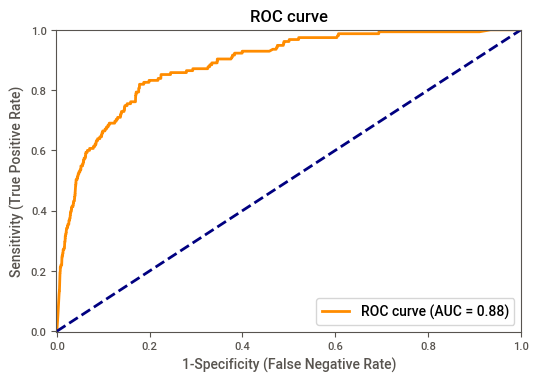

In [363]:
plot_roc(y_test, y_pred_proba[:,1])

In [364]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[24582  3125]
 [   49   106]]


In [365]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(24582, 3125, 49, 106)

In [366]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     27707
           1       0.03      0.68      0.06       155

    accuracy                           0.89     27862
   macro avg       0.52      0.79      0.50     27862
weighted avg       0.99      0.89      0.93     27862



In [381]:
# for plotting the one of the tree from RF model
randsearch_model.best_estimator_[1].estimators_[1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=914636141, splitter='best')

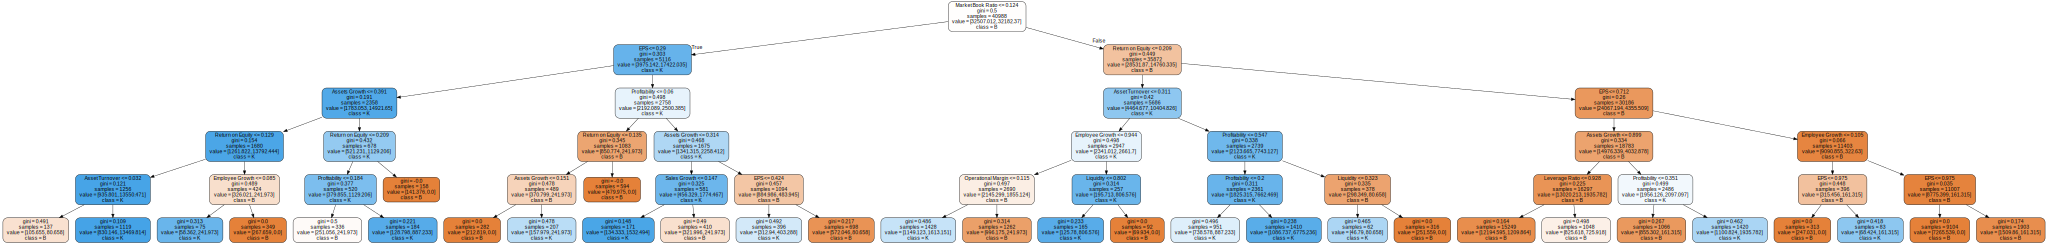

In [382]:
# for plotting the one of the tree from RF model
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
                           randsearch_model.best_estimator_[1].estimators_[1],
                           feature_names = X_train.columns.to_list(),
                            class_names = 'BK',
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

## Model: Naive Bayes, under sampling (NB model does not have class_weight)

In [383]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_transformed, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [384]:
X_train_resampled.shape, y_train_resampled.shape

((806, 12), (806,))

In [385]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns.to_list())

In [386]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

In [387]:
nb_pipeline = Pipeline(steps=[
                    ('preprocess', data_pipeline),
                    ('model', nb_model)])

In [388]:
# fit pipeline with model
nb_pipeline.fit(X_train_resampled, y_train_resampled)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (806). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa66eeb3110>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [389]:
# predictions from pipeline
y_pred_proba = nb_pipeline.predict_proba(X_test)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [390]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.8176532773248171

In [391]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {
                 "model__var_smoothing": np.logspace(0,-9, num=100)
                 }
            ]

In [392]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# create a gridsearch of the pipeline, the fit the best model
randsearch = RandomizedSearchCV(nb_pipeline, grid_param, cv=5, verbose=0, n_jobs=-1, scoring = score_func) # Fit grid search

In [393]:
randsearch_model = randsearch.fit(X_train,y_train)

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


In [394]:
randsearch_model.best_score_

0.7616449120696519

In [395]:
randsearch_model.best_params_

{'model__var_smoothing': 0.0008111308307896872}

In [396]:
randsearch_model.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('remove_outlier',
                                                                   <__main__.CustomTransformer object at 0x7fa66eb04090>),
                                                                  ('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                     

In [397]:
# predict probability on X_test
y_pred_proba = randsearch_model.predict_proba(X_test)
y_pred_proba

capping the  EPS
capping the  Liquidity
capping the  Profitability
capping the  Productivity
capping the  Leverage Ratio
capping the  Asset Turnover
capping the  Operational Margin
capping the  Return on Equity
capping the  Market Book Ratio
capping the  Assets Growth
capping the  Sales Growth


array([[9.47803536e-01, 5.21964635e-02],
       [9.99995133e-01, 4.86682726e-06],
       [9.98934973e-01, 1.06502728e-03],
       ...,
       [9.99999984e-01, 1.57850045e-08],
       [9.99999999e-01, 7.21135137e-10],
       [3.87003447e-02, 9.61299655e-01]])

In [398]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.858380961140599

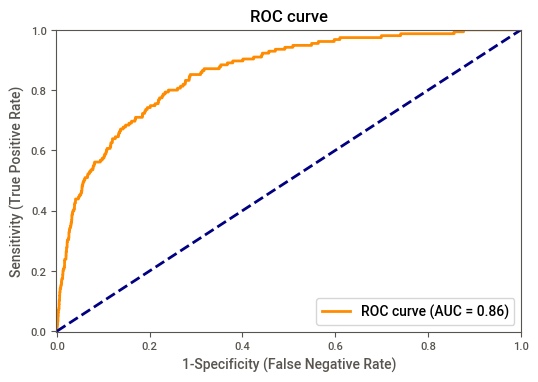

In [399]:
plot_roc(y_test, y_pred_proba[:,1])

In [400]:
# confusion matrix
y_pred = np.where(y_pred_proba[:,1] > class_threshold, 1, 0) # applying the threshold rule to classify

print(confusion_matrix(y_test, y_pred))

[[25381  2326]
 [   68    87]]


In [401]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(25381, 2326, 68, 87)

In [402]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.95     27707
           1       0.04      0.56      0.07       155

    accuracy                           0.91     27862
   macro avg       0.52      0.74      0.51     27862
weighted avg       0.99      0.91      0.95     27862

